In [1]:
# %matplotlib widget
%matplotlib inline

import numpy as np
import cmath
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import kvn
import pylib.Chebyschev_coefs as ch
import pylib.qucf_read as qucf_r

35324
c:\Users\novikau1\Documents\work\codes\QuCF\scripts-py


In [2]:
# ---------------------------------------------------------------------------------------------------
# --- Some global parameters ---
# ---------------------------------------------------------------------------------------------------
cmap_matrix = 'bwr'
cmap_two_signs_= 'coolwarm'
cmap_two_signs_= 'Blues'
def fmt_(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)
colors_ = ["b", "r", "g", "magenta", "black"]

path_save_ = "./jupyter-notebooks/NL/results/"

In [8]:
for _ in range(30):
    plt.close()

In [4]:
# ---------------------------------------------------------------------------------------------------
# --- Prepare intial parameters ---
# ---------------------------------------------------------------------------------------------------
mix.reload_module(kvn)

# --- two attractors ---
F_ = lambda x:  - x* (x**2 - 0.25)

# t_max, x_max, x_center = 4.0, 1, -0.8
# x_centers_ = [- x_center, x_center, 0.5*x_center, - 0.5*x_center] 

# t_max, x_max, x_center = 4.0, 1, 0.125
# x_centers_ = [- x_center, x_center, 6.*x_center, - 6.*x_center] 

t_max, x_max, x_center = 4.0, 1, 0.25
x_centers_ = [- x_center, x_center, 3.*x_center, - 3.*x_center] 
# ----------------------------------------

flag_sim_ = True # if False, then only plot the resulting matrices;

if flag_sim_:
    nx, nt = 7, 11  # for simulations
else:
    # nx, nt = 3, 11  # for plotting
    nx, nt = 4, 11  # for plotting

Nx = 1<<nx
Nt = 1<<nt
x = np.linspace(-x_max, x_max, Nx)
t = np.linspace(0,t_max,Nt)
dx = np.diff(x)[0]
dt = np.diff(t)[0]

# ------------------------------------------------------
psi_init_ = np.zeros(Nx, dtype=float)
delta_gauss = 0.05
coef_gauss = 1./(np.sqrt(2.*np.pi) * delta_gauss)
for ii in range(Nx):
    psi_init_[ii] = 0
    for i_center in range(len(x_centers_)):
        psi_init_[ii] += np.exp(-(x[ii] + x_centers_[i_center])**2/(2.*delta_gauss**2)) 
psi_init_[0] = 0
psi_init_[Nx-1] = 0
del ii


print("nx: {:d}".format(nx))
print("nt: {:d}".format(nt))
print("sum psi**2: {:0.3e}".format(np.trapz(psi_init_**2, dx=dx)))

sol_ref_several = []


# --- Form the KvN Hamiltonian ---
print()
print("--- CENTRAL DIFFERENCE SCHEME ---")
H_CD     = kvn.construct_CD_matrix_1D(x, F_)
kvn.is_Hermitian(H_CD, "CD")

print("--- UPWINDING DIFFERENCE SCHEME ---")
H_UW, Aa_v1, Ah_v1, Aa_v2, Ah_v2 = kvn.construct_UW_matrix_1D(x, F_)
kvn.is_Hermitian(H_UW, "UW")

nx: 7
nt: 11
sum psi**2: 3.545e-01

--- CENTRAL DIFFERENCE SCHEME ---
the matrix CD is Hermitian
--- UPWINDING DIFFERENCE SCHEME ---
the matrix UW is non-Hermitian


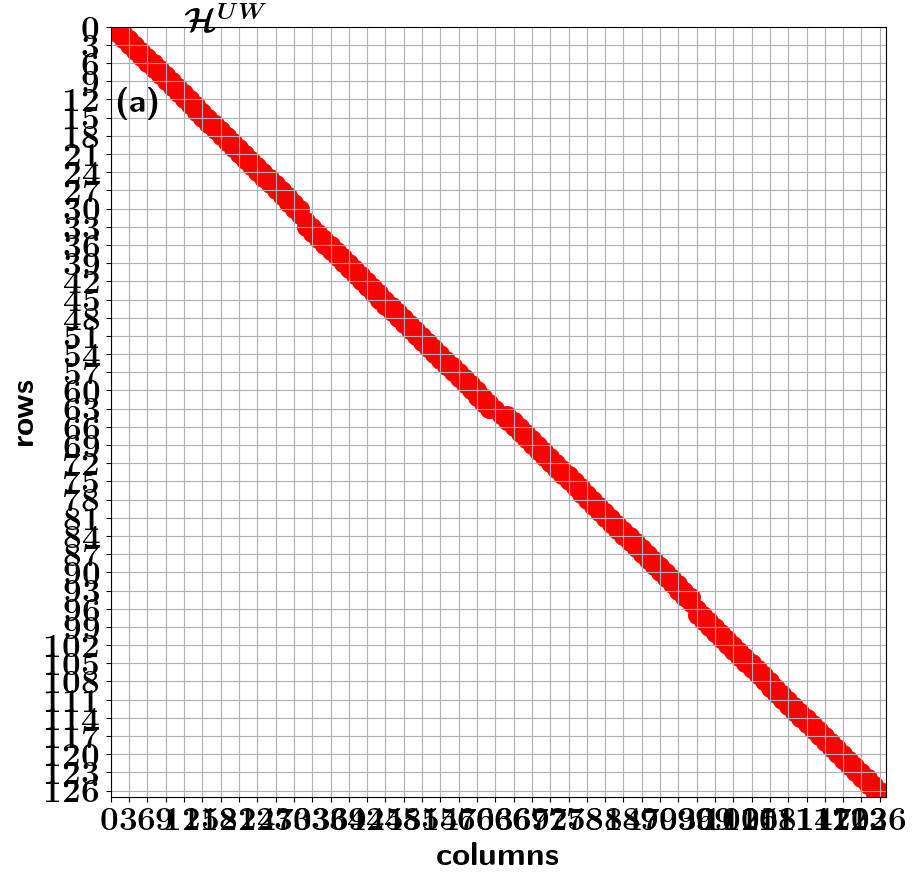

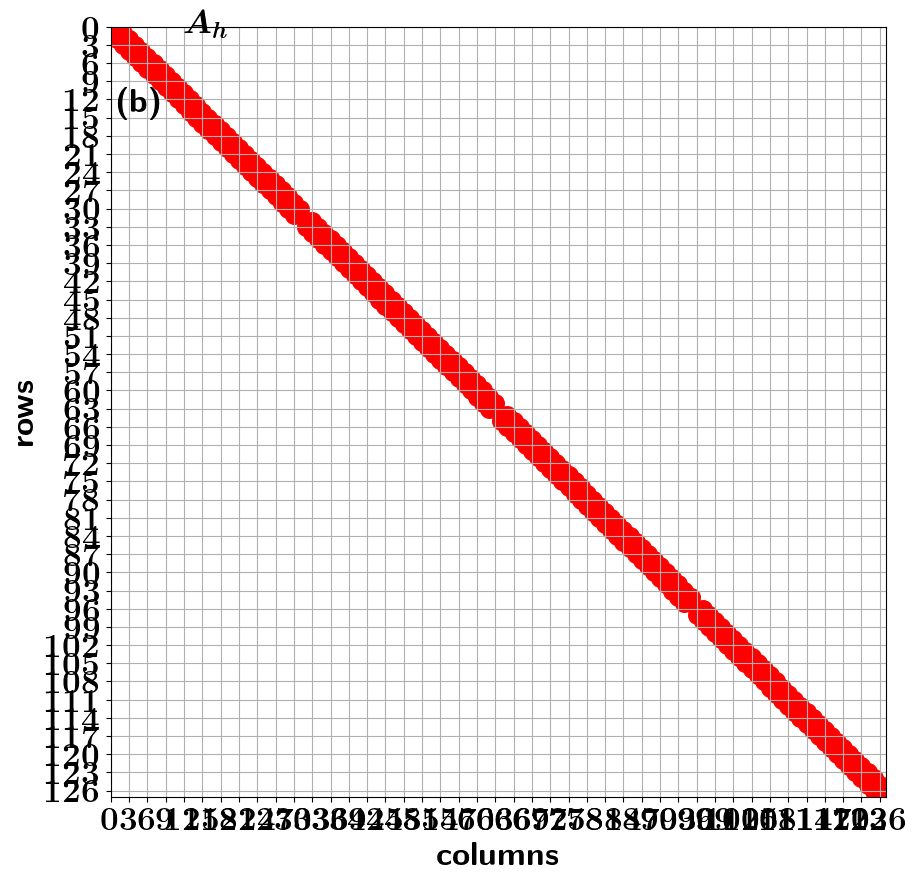

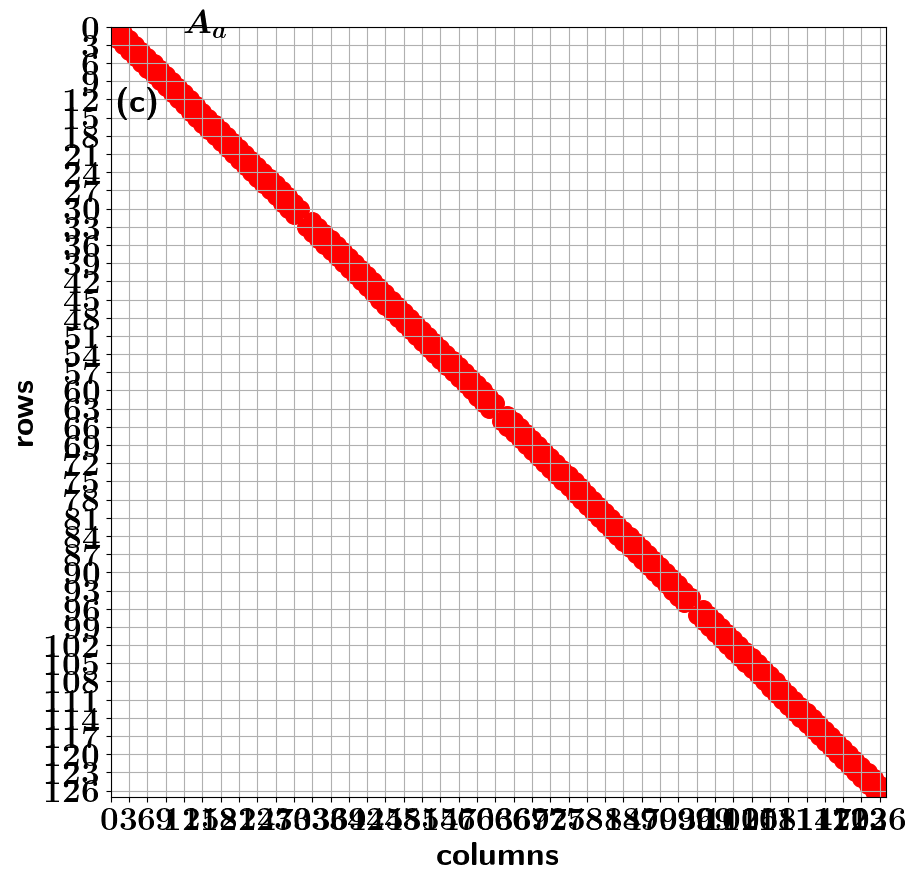

In [7]:
# ---------------------------------------------------
# --- Plot the structure of the original matrices ---
# ---------------------------------------------------
mix.reload_module(kvn)

if not flag_sim_:
    flag_save = False
    
    # matrix_labels = ["", "", ""]
    matrix_labels = ["(a)", "(b)", "(c)"]
    
    kvn.plot_A_structure(
        H_UW, "\mathcal{H}^{UW}",
        matrix_labels[0], "fig_x2_H",
        flag_save = flag_save, 
        path_save = path_save_
    )
    kvn.plot_A_structure(
        Ah_v1, "A_h",
        matrix_labels[1], "fig_x2_Ah",
        flag_save = flag_save, 
        path_save = path_save_
    )
    kvn.plot_A_structure(
        Aa_v1, "A_a",
        matrix_labels[2], "fig_x2_Aa",
        flag_save = flag_save, 
        path_save = path_save_
    )
    del flag_save, matrix_labels
else:
    print("Plotting of matrices is blocked.")

In [10]:
# --------------------------------------------------------------------
# --- Compare matrices computed in different ways ---
# --------------------------------------------------------------------
mix.reload_module(mix)

if not flag_sim_:
    mix.print_matrix_colored(Ah_v1)
    print()
    mix.print_matrix_colored(Ah_v2)
    print()
mix.compare_matrices_dense(Aa_v1, Aa_v2, prec = 1e-12)
mix.compare_matrices_dense(Ah_v1, Ah_v2, prec = 1e-12)
print("Done.")

the same within precision  1e-12
the same within precision  1e-12
Done.


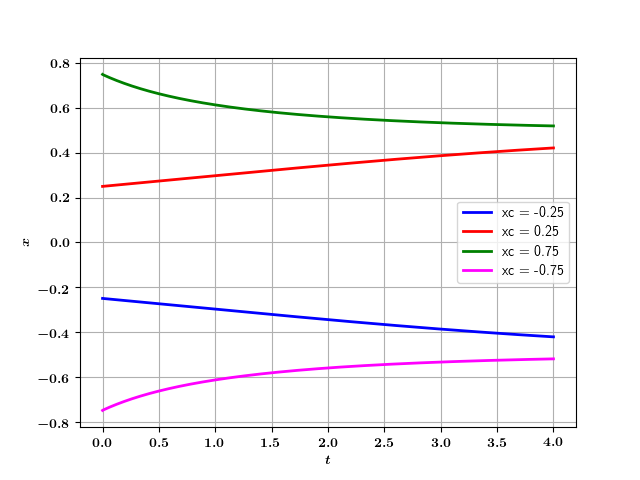

In [28]:
# -----------------------------------------------------------------
# --- Solve d x / d t = - x**2: standart method (for reference) ---
# -----------------------------------------------------------------
from scipy.integrate import RK45
mix.reload_module(mix)
mix.reload_module(kvn)

def solve_standart(x_center_ref):
    oo = RK45(
        lambda t,x: F_(x), 
        t[0], 
        [x_center_ref], t[-1], first_step=dt, max_step=dt
    )
    
    sol_ref = np.zeros(Nt, dtype=float)
    sol_ref[0] = x_center_ref
    Nt_act = 1
    
    oo.step()
    oo.t
    while mix.compare_two_strings(oo.status, "running"):
        oo.step()
        Nt_act += 1
        if Nt_act - 1 == Nt:
            print(oo.t)
        sol_ref[Nt_act-1] = float(oo.y[0])
    return sol_ref
# --------------------------------------------------------------------------

if flag_sim_:
    sol_refs = []
    plt.close()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i_center in range(len(x_centers_)):
        x_center = x_centers_[i_center]
    
        # --- Solve for the particular x_center ---
        sol_one = solve_standart(x_center)
        sol_refs.append(sol_one)
    
        # --- Plotting ---
        ax.plot(
            t, sol_one, 
            color=colors_[i_center], linewidth = 2, linestyle='-', 
            label = "xc = {:0.2f}".format(x_center)
        )
        del x_center
    plt.xlabel('$t$')
    plt.ylabel("$x$")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Simulations are blocked.")

In [ ]:
# ***********************************************************************************************************
# ***********************************************************************************************************
# ***********************************************************************************************************

In [29]:
# --------------------------------------------------------------------------------
# --- Solve the system by using the KvN Hamiltonian ---
# --------------------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(kvn)
from numba import njit
import time

# --- computation ---
if flag_sim_:
    st = time.time()
    
    psi_tx_matrix_CD   = kvn.solve_KvN_1D_using_Hamiltonian(t, Nx, psi_init_, H_CD)
    psi_tx_matrix_UW   = kvn.solve_KvN_1D_using_Hamiltonian(t, Nx, psi_init_, H_UW)
    
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    
    # --- Compute the mean value ---
    mean_t_CD   = kvn.compute_mean_1D(x, Nt, psi_tx_matrix_CD)
    mean_t_UW   = kvn.compute_mean_1D(x, Nt, psi_tx_matrix_UW)
else:
    print("Simulations are blocked.")

Execution time: 0.5855069160461426 seconds


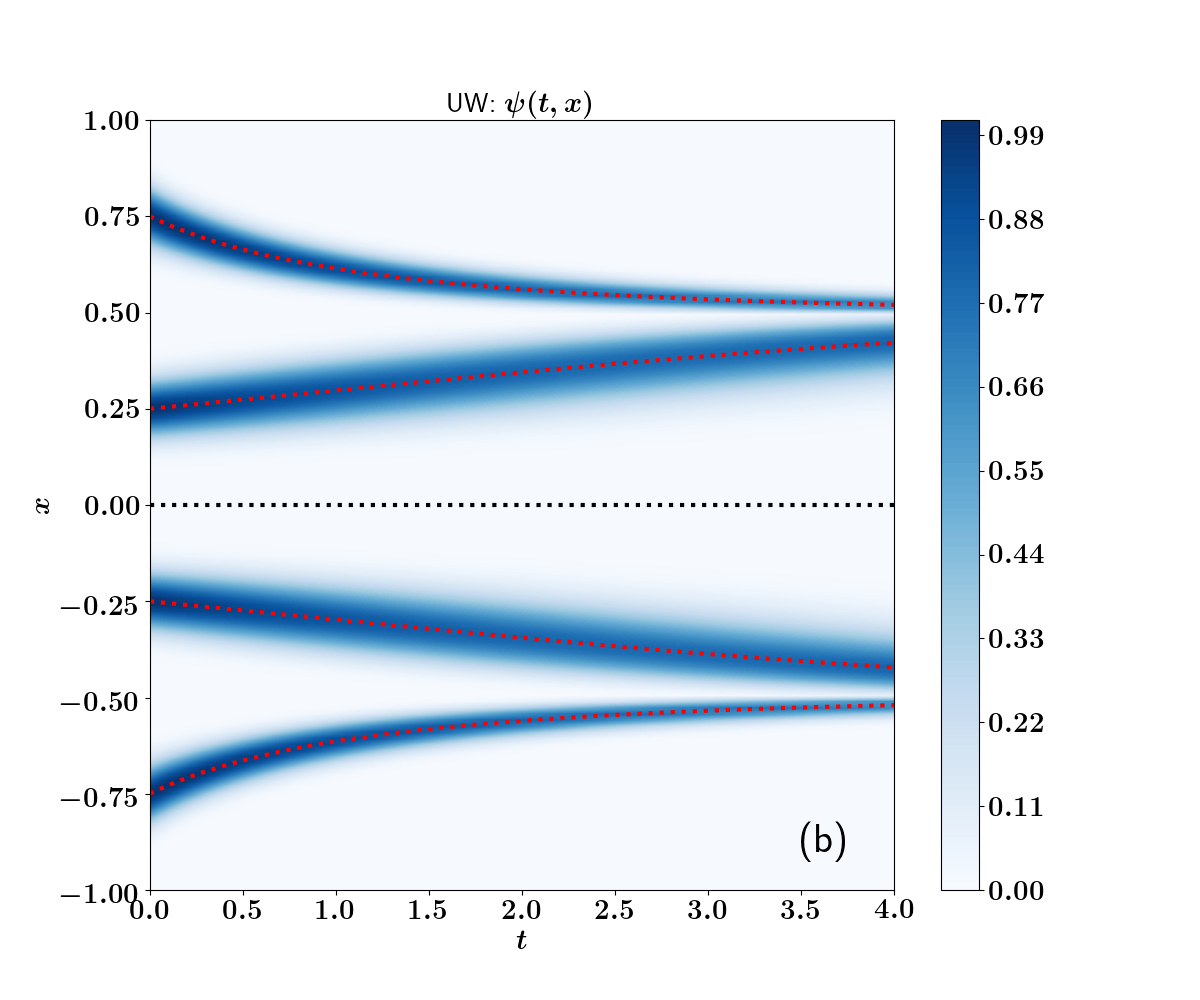

In [30]:
# ---------------------------------------------------------------------------------------------------
# --- Plot psi_tx_matrix(t,x) ---
# ---------------------------------------------------------------------------------------------------
if flag_sim_:
    # psi_tx_plot, mean_t_plot, str_title, str_fig = psi_tx_matrix_CD, mean_t_CD, "CD: ", "(a)"
    psi_tx_plot, mean_t_plot, str_title, str_fig = psi_tx_matrix_UW, mean_t_UW, "UW: ", "(b)"
    
    fontsize = 20
    
    # --- Plotting ---
    XX, YY = np.meshgrid(t, x)
    fig_tx = plt.figure(figsize=(12, 10))
    ax = fig_tx.add_subplot(111)
    cs = ax.contourf(XX, YY, np.transpose(psi_tx_plot.real), levels=100, cmap=cmap_two_signs_)
    
    # cb = fig_tx.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
    cb = fig_tx.colorbar(cs, ax = ax)
    cb.ax.ticklabel_format(style="scientific")
    cb.ax.tick_params(labelsize=fontsize) 
    
    ax.plot(t, mean_t_plot, color='black', linewidth = 3.0, linestyle=':', label="mean")
    
    ax.plot(t, sol_refs[0], color='r', linewidth = 3.0, linestyle=':', label="ref")
    for i_ref in range(1,len(sol_refs)):
        ax.plot(t, sol_refs[i_ref], color='r', linewidth = 3.0, linestyle=':')
    
    # ax.legend()
    ax.set_xlabel('$t$', fontsize = fontsize)
    ax.set_ylabel('$x$', fontsize = fontsize)
    ax.set_title(str_title + '$\psi(t,x)$', fontsize = fontsize)
    ax.set_xlim(0, t_max)
    ax.set_ylim(-x_max, x_max)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.text(3.5, -0.9, str_fig, fontsize=1.5*fontsize)
    
    del fontsize, fig_tx
else:
    print("Simulations are blocked.")

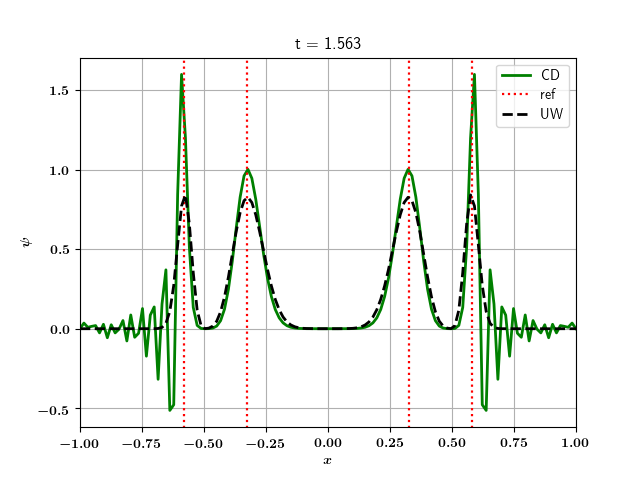


--- reference points ---
-3.247e-01
3.247e-01
5.789e-01
-5.789e-01

chosen time moment: 1.563


In [14]:
# ---------------------------------------------------------------------------------------------------
# --- Plot psi(x) at different t ---
# ---------------------------------------------------------------------------------------------------

flag_save = False
fname_CD = "CD_x_t1.dat"
fname_UW = "UW_x_t1.dat"
idt_moment = 160*5

# ------------------------------------------------------------
if flag_sim_:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(
        x, psi_tx_matrix_CD.real[idt_moment,:], 
        color="green", linewidth = 2.0, linestyle='-',
        label = "CD"
    )
    ax.axvline(
        sol_refs[0][idt_moment], 
        ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1]*2, 
        color = "r", linewidth = 1.6, linestyle = ":",
        label = "ref"
    )
    for i_center in range(1, len(sol_refs)):
        ax.axvline(
            sol_refs[i_center][idt_moment], 
            ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1]*2, 
            color = "r", linewidth = 1.6, linestyle = ":"
        )
    ax.plot(
        x, psi_tx_matrix_UW.real[idt_moment,:], 
        color="black", linewidth = 2.0, linestyle='--',
        label = "UW"
    )
    plt.xlim([-x_max,x_max])
    plt.xlabel('$x$')
    plt.ylabel("$\psi$")
    plt.title("t = {:0.3f}".format(t[idt_moment]))
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- Save the 1D data ---
    if flag_save:
        mix.save_dat_plot_1d_file(
            path_save_ + "/" + fname_CD, 
            x, 
            psi_tx_matrix_CD.real[idt_moment,:]
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/" + fname_UW, 
            x, 
            psi_tx_matrix_UW.real[idt_moment,:]
        )
    # --- Print the reference points ---
    print("\n--- reference points ---")
    for i_center in range(len(sol_refs)):
        print("{:0.3e}".format(sol_refs[i_center][idt_moment]))
    print()
    print("chosen time moment: {:0.3f}".format(t[idt_moment]))
else:
    print("Simulations are blocked.")

del idt_moment, flag_save, fname_CD, fname_UW

In [ ]:
# ***********************************************************************************************************
# ***********************************************************************************************************
# ***********************************************************************************************************

In [20]:
# ----------------------------------------------------------------------
# --- LCHS simulation (in python) ---
# ----------------------------------------------------------------------
mix.reload_module(kvn)
def LCHS_py(kmax, nk, ids_t_LCHS_py):
    print()
    print("--- Case: kmax = {:0.1f}, nk = {:d}".format(kmax, nk))

    # --- k-grid ---
    k_grid     = np.linspace(- kmax, kmax, 1 << nk)

    # --- computation ---
    psi_LCHS_py = np.zeros((len(ids_t_LCHS_py), Nx), dtype = complex)
    for counter_t in range(len(ids_t_LCHS_py)):
        id_t_LCHS_py = ids_t_LCHS_py[counter_t]
        print("LCHS at t = {:0.3e}".format(t[id_t_LCHS_py]))
        psi_LCHS_py[counter_t, :] = kvn.LCHS_computation(
            k_grid, dt,
            1.j*H_UW, psi_init_, id_t_LCHS_py, 
            flag_trotterization = True, 
            flag_print = False
        )
    print("Done.")
    
    # save results:
    dd = {
        "psi": psi_LCHS_py,
        "nk": nk,
        "kmax": kmax
    }
    return dd

def gkL(kmax, nk):
    return format("{:0.1f} {:d}".format(kmax, nk))
# ------------------------------------------------------------------------

# time points where the LCHS statevector is calculated: 
ids_t_LCHS_py = [
    Nt//3, 
    Nt//2, 
    Nt//10*9
]
dds_LCHS_py = {}

kmax, nk = 10., 5
dds_LCHS_py[gkL(kmax, nk)] = LCHS_py(kmax, nk, ids_t_LCHS_py)

kmax, nk = 10., 7
dds_LCHS_py[gkL(kmax, nk)] = LCHS_py(kmax, nk, ids_t_LCHS_py)

kmax, nk = 10., 8
dds_LCHS_py[gkL(kmax, nk)] = LCHS_py(kmax, nk, ids_t_LCHS_py)

kmax, nk = 20., 8
dds_LCHS_py[gkL(kmax, nk)] = LCHS_py(kmax, nk, ids_t_LCHS_py)

kmax, nk = 40., 9
dds_LCHS_py[gkL(kmax, nk)] = LCHS_py(kmax, nk, ids_t_LCHS_py)


--- Case: kmax = 20.0, nk = 8
LCHS at t = 1.333e+00
LCHS at t = 2.001e+00
LCHS at t = 3.588e+00
Done.

--- Case: kmax = 40.0, nk = 9
LCHS at t = 1.333e+00
LCHS at t = 2.001e+00
LCHS at t = 3.588e+00
Done.


In [25]:
# ----------------------------------------------------------------------
# --- Plot results from the python LCHS simulation ---
# ----------------------------------------------------------------------
def plot_LCHS_py(dds):
    for counter_t in range(len(ids_t_LCHS_py)):
        id_t_LCHS_py = ids_t_LCHS_py[counter_t]

        print()
        print("chosen time moment: {:0.3f}".format(t[id_t_LCHS_py]))
        
        colors_loc = ["green", "blue", "black", "magenta"]
        line_styles = ["-", "--", "--"]

        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        for ii in range(len(dds)):
            ax.plot(
                x, 
                dds[ii]["psi"].real[counter_t, :], 
                color=colors_loc[ii], 
                linewidth = 2.0, 
                linestyle=line_styles[ii],
                label = "kmax = {:0.1f}, nk = {:d}".format(
                    dds[ii]["kmax"], dds[ii]["nk"]
                )
            )
        
        ax.axvline(
            sol_refs[0][id_t_LCHS_py], 
            ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1]*2, 
            color = "r", linewidth = 1.6, linestyle = ":",
            label = "ref"
        )
        for i_center in range(1, len(sol_refs)):
            ax.axvline(
                sol_refs[i_center][id_t_LCHS_py], 
                ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1]*2, 
                color = "r", linewidth = 1.6, linestyle = ":"
            )
        plt.xlim([-x_max,x_max])
        plt.xlabel('$x$')
        plt.ylabel("$Re[\psi]$")
        plt.title("t = {:0.3f}".format(t[id_t_LCHS_py]))
        plt.grid(True)
        plt.legend()
        plt.show()

    
def save_LCHS_py(kmax, nk, fname_LCHS_py, counter_t):
    fname = "{:s}{:d}_k{:d}_n{:d}.dat".format(
        fname_LCHS_py, counter_t, int(kmax), nk
    )
    mix.save_dat_plot_1d_file(
        path_save_ + "/" + fname, 
        x, 
        dds_LCHS_py[gkL(kmax, nk)]["psi"].real[counter_t,:]
    )
    
    
# -----------------------------------------------------------------------------------------
    
    
flag_save = False
flag_plot = False

# kmax_plot, nk_plot = [10, 10, 10], [5, 7, 8]
kmax_plot, nk_plot = [10, 20, 40], [7, 8, 9]


# --- Plotting ---
if flag_plot:
    dds_plot = [
        dds_LCHS_py[gkL(kmax_plot[0], nk_plot[0])],
        dds_LCHS_py[gkL(kmax_plot[1], nk_plot[1])],
        dds_LCHS_py[gkL(kmax_plot[2], nk_plot[2])]
    ]
    plot_LCHS_py(dds_plot)
    
# --- Print reference peaks ---
print()
for counter_t in range(len(ids_t_LCHS_py)):
    id_t_LCHS_py = ids_t_LCHS_py[counter_t]
    print("--- t{:d} = {:0.3f} ---".format(
        counter_t, t[id_t_LCHS_py]
    ))
    for i_center in range(len(sol_refs)):
        print("{:0.3e}".format(sol_refs[i_center][id_t_LCHS_py]))

# --- Save the 1D data ---
if flag_save:
    print()
    fname_LCHS_py = "LCHS_py_x_t"
    for counter_t in range(len(ids_t_LCHS_py)):
        save_LCHS_py(kmax_plot[0], nk_plot[0], fname_LCHS_py, counter_t)
        save_LCHS_py(kmax_plot[1], nk_plot[1], fname_LCHS_py, counter_t)
        save_LCHS_py(kmax_plot[2], nk_plot[2], fname_LCHS_py, counter_t)

del flag_save


--- t0 = 1.333 ---
-3.138e-01
3.138e-01
5.913e-01
-5.913e-01
--- t1 = 2.001 ---
-3.449e-01
3.449e-01
5.604e-01
-5.604e-01
--- t2 = 3.588 ---
-4.085e-01
4.085e-01
5.248e-01
-5.248e-01


In [8]:
# ***********************************************************************************************************
# ***********************************************************************************************************
# ***********************************************************************************************************

In [12]:
# ----------------------------------------------------------
# --- Parameters for the LCHS simulation ---
# > Normalize matrices.
# ----------------------------------------------------------
mix.reload_module(kvn)

# --- LCHS parameters ---
nk_    = 7
k_max_ = 10

# - k-grid -
Nk_    = 1 << nk_
k_     = np.linspace(-k_max_, k_max_, Nk_)
dk_    = np.diff(k_)[0]

# --- LCHS matrices ---
print("--- OPTION 1 -----------")
Ba_norm_v1, B_kmax_norm_v1, Bk_norm_v1 = kvn.compute_norm_matrices_LCHS(Aa_v1, Ah_v1, k_max_, dk_)
print()
print("--- OPTION 2 -----------")
Ba_norm_v2, B_kmax_norm_v2, Bk_norm_v2 = kvn.compute_norm_matrices_LCHS(Aa_v2, Ah_v2, k_max_, dk_)

print()
print(" ----------------------------------------------------------------")
mix.compare_matrices_dense(Ba_norm_v1,     Ba_norm_v2,     prec = 1e-12)
mix.compare_matrices_dense(B_kmax_norm_v1, B_kmax_norm_v2, prec = 1e-12)
mix.compare_matrices_dense(Bk_norm_v1,     Bk_norm_v2, prec = 1e-12)

# --- Parameters for the SIN-gate ---
alpha_x0 = - 1.0
alpha_x1 = np.abs(alpha_x0) * Nx/(Nx - 1)
print("\n// --- Parameters for the SIN-X-gate ---")
print("nx \t{:d}".format(nx))
print("alpha_x0 \t{:0.12e}".format(alpha_x0))
print("alpha_x1 \t{:0.12e}".format(alpha_x1))

--- OPTION 1 -----------
Matrix Ba:	 nonsparsity, coefnorm: 2, 6.359e+01
Matrix B_kmax:	 nonsparsity, coefnorm: 3, 1.651e+03
Matrix Bk:	 nonsparsity, coefnorm: 3, 2.600e+01

norm of Ba_norm_:     0.500
norm of B_kmax_norm_: 0.333
norm of Bk_norm_:     0.333

--- OPTION 2 -----------
Matrix Ba:	 nonsparsity, coefnorm: 2, 6.359e+01
Matrix B_kmax:	 nonsparsity, coefnorm: 3, 1.651e+03
Matrix Bk:	 nonsparsity, coefnorm: 3, 2.600e+01

norm of Ba_norm_:     0.500
norm of B_kmax_norm_: 0.333
norm of Bk_norm_:     0.333

 ----------------------------------------------------------------
the same within precision  1e-12
the same within precision  1e-12
the same within precision  1e-12

// --- Parameters for the SIN-X-gate ---
nx 	7
alpha_x0 	-1.000000000000e+00
alpha_x1 	1.007874015748e+00



-------------------------------------------------------------------------
--- Ba-norm ---


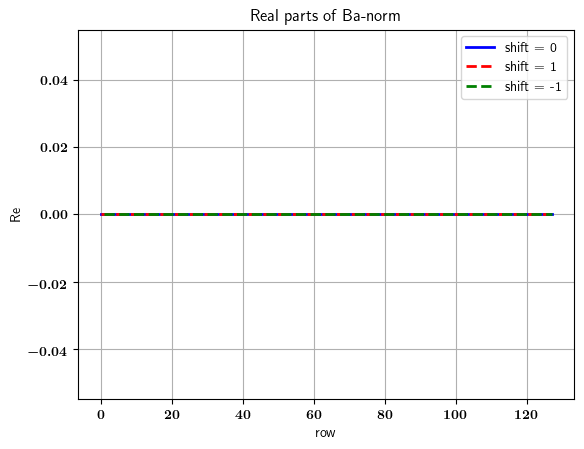

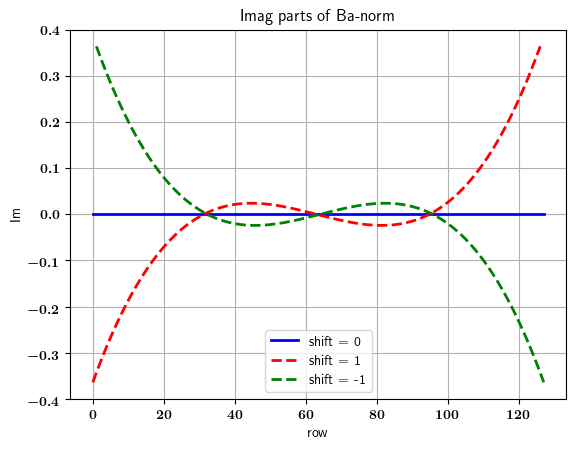

write data to a file: ./jupyter-notebooks/NL/results///Ba-norm_diag_0
write data to a file: ./jupyter-notebooks/NL/results///Ba-norm_diag_1
write data to a file: ./jupyter-notebooks/NL/results///Ba-norm_diag_-1

-------------------------------------------------------------------------
--- B-kmax-norm ---


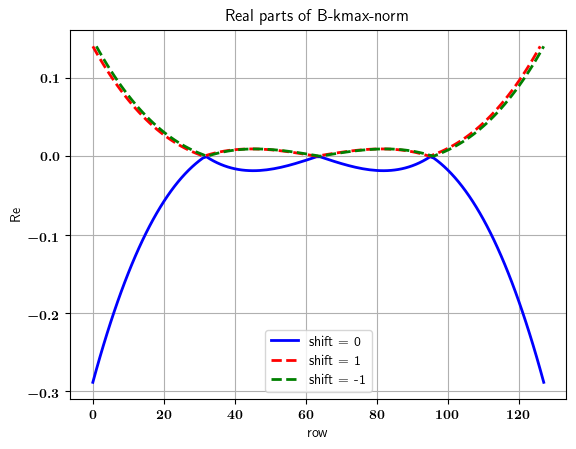

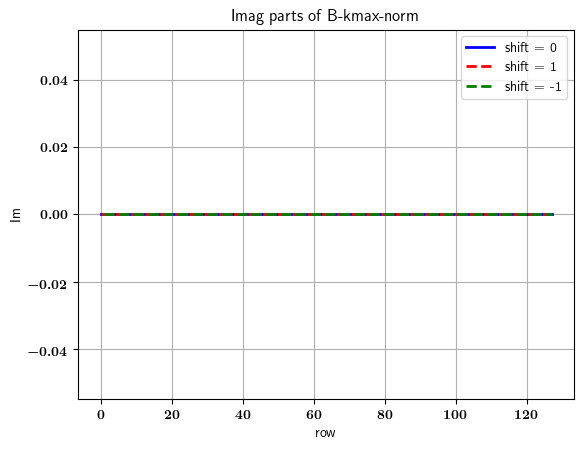

write data to a file: ./jupyter-notebooks/NL/results///B-kmax-norm_diag_0
write data to a file: ./jupyter-notebooks/NL/results///B-kmax-norm_diag_1
write data to a file: ./jupyter-notebooks/NL/results///B-kmax-norm_diag_-1


In [19]:
# ---------------------------------------------------------------
# --- Print diagonals of normalized (non-rescaled) matrices ---
# ---------------------------------------------------------------
mix.reload_module(kvn)

def plot_save_diagonals(A_plot, A_name, flag_save, flag_save_real):

    def save_data(rows_loc, diag_loc, sh_loc):
        full_name = path_save_ + "//" + A_name + "_diag_{:d}".format(sh_loc)
        if flag_save_real:
            yx_loc = diag_loc.real
        else:
            yx_loc = diag_loc.imag
        mix.save_dat_plot_1d_file(full_name, rows_loc, yx_loc)
        return
    # ----------------------------------------

    sh_1 = 0
    diag_1, rows_1 = kvn.get_diag(A_plot, i_shift = sh_1)

    sh_2 = 1
    diag_2, rows_2 = kvn.get_diag(A_plot, i_shift = sh_2)

    sh_3 = -1
    diag_3, rows_3 = kvn.get_diag(A_plot, i_shift = sh_3)


    # --- Real parts ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(rows_1, diag_1.real, color='b', linewidth = 2, linestyle='-', label = "shift = {:d}".format(sh_1))
    ax.plot(rows_2, diag_2.real, color='r', linewidth = 2, linestyle='--', label = "shift = {:d}".format(sh_2))
    ax.plot(rows_3, diag_3.real, color='g', linewidth = 2, linestyle='--', label = "shift = {:d}".format(sh_3))
    plt.xlabel('row')
    plt.ylabel("Re")
    plt.title("Real parts of {:s}".format(A_name))
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Imaginary parts ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(rows_1, diag_1.imag, color='b', linewidth = 2, linestyle='-', label = "shift = {:d}".format(sh_1))
    ax.plot(rows_2, diag_2.imag, color='r', linewidth = 2, linestyle='--', label = "shift = {:d}".format(sh_2))
    ax.plot(rows_3, diag_3.imag, color='g', linewidth = 2, linestyle='--', label = "shift = {:d}".format(sh_3))
    plt.xlabel('row')
    plt.ylabel("Im")
    plt.title("Imag parts of {:s}".format(A_name))
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Saving ---
    if flag_save:
        save_data(rows_1, diag_1, sh_1)
        save_data(rows_2, diag_2, sh_2)
        save_data(rows_3, diag_3, sh_3)
    return
# --------------------------------------------------------------------

flag_save = True

print()
print("-------------------------------------------------------------------------")
print("--- Ba-norm ---")
A_plot, A_name, flag_save_real = Ba_norm_v1,     "Ba-norm",     False
plot_save_diagonals(A_plot, A_name, flag_save, flag_save_real)

print()
print("-------------------------------------------------------------------------")
print("--- B-kmax-norm ---")
A_plot, A_name, flag_save_real = B_kmax_norm_v1, "B-kmax-norm", True
plot_save_diagonals(A_plot, A_name, flag_save, flag_save_real)

# A_plot, A_name, flag_save_real = Bk_norm_v1,     "Bk-norm",     True
# A_plot, A_name, flag_save_real  = Ah_, "Ah", True
# A_plot, A_name, flag_save_real  = Aa_, "Aa", False
del flag_save, A_plot, A_name, flag_save_real

In [8]:
# ---------------------------------------------------------------
# --- Rescale matrices to the bulk elements of the D-matrices ---
# ---------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(kvn)

# Diagonals rescaled to the bulk elements of D-matrices:
diag_A_m1 = kvn.get_diag(Ba_norm_v1, -1)[0].imag / 0.500
diag_A_p1 = kvn.get_diag(Ba_norm_v1,  1)[0].imag  / 0.500

coef_mp1, coef_0 = 0.250, 0.500
diag_kmax_m1 = kvn.get_diag(B_kmax_norm_v1, -1)[0].real / coef_mp1
diag_kmax_00 = kvn.get_diag(B_kmax_norm_v1,  0)[0].real / coef_0
diag_kmax_p1 = kvn.get_diag(B_kmax_norm_v1,  1)[0].real / coef_mp1

diag_k_m1 = kvn.get_diag(Bk_norm_v1, -1)[0].real / coef_mp1
diag_k_00 = kvn.get_diag(Bk_norm_v1,  0)[0].real / coef_0
diag_k_p1 = kvn.get_diag(Bk_norm_v1,  1)[0].real / coef_mp1

Chosen profile: prof_A_m1
Chosen parity: 1

Minimization method is used.
Computation status:  6.500482197149578e-06

x[0] =  -0.999923511388017
x[-1] =  0.999923511388017
Chosen polynomial's degree:	 100
Number of coefficients:		 50
max. abs. error: 7.087e-04


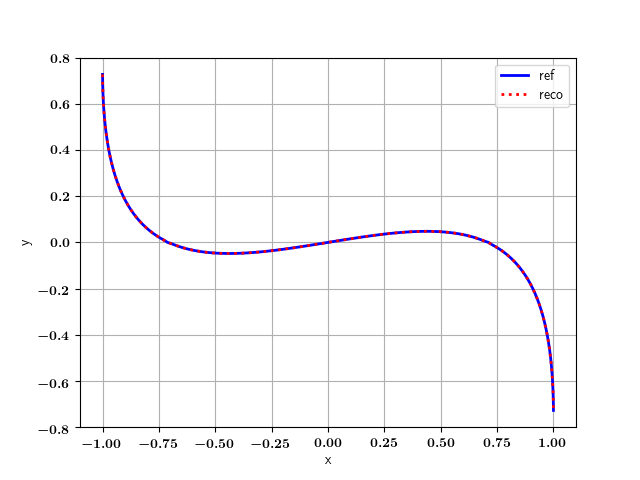

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


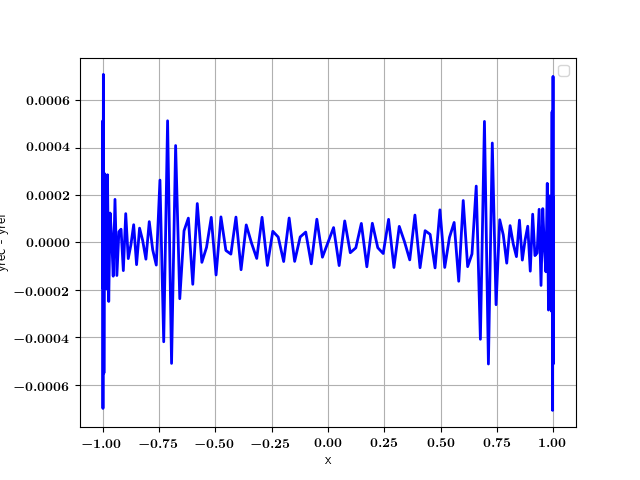

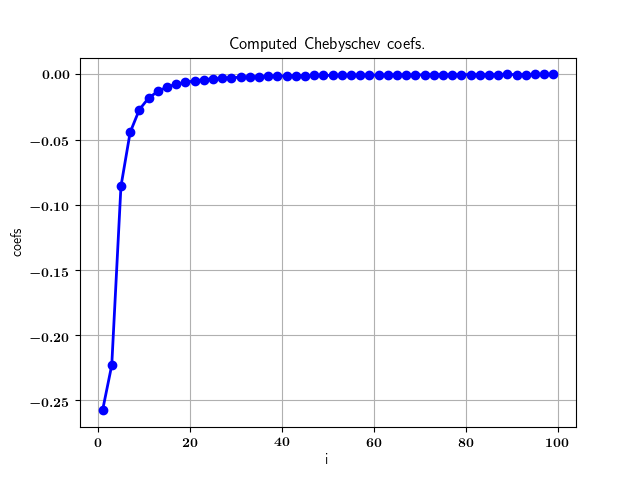

write angles to:
 ./jupyter-notebooks/NL/BE/coefs//prof_A_m1__eps3.hdf5


In [21]:
# --------------------------------------------------------------------------------------
# --- Compute the Chebyschev coefficients for the QSVT computations of the BE oracle ---
# --------------------------------------------------------------------------------------
mix.reload_module(ch)
mix.reload_module(kvn)

def compute_coefs(diag_ch, name_prof_1, parity_1, Nd, flag_save = False):
    sel_method = 0

    oo_ch_ = ch.Ch_()
    oo_ch_.choose_method(sel_method)
    oo_ch_.choose_func(
        -1, 0.0, 
        profile_in = diag_ch,
        name_prof  = name_prof_1,
        parity_in  = parity_1,
        path_root_in = "./jupyter-notebooks/NL/BE/coefs/"
    )
    oo_ch_.compute_Ch(Nd)
    oo_ch_.plot_reconstructed_function()
    oo_ch_.plot_errors()
    oo_ch_.plot_coefficients()

    if flag_save:
        oo_ch_.save_coefficients()

    return oo_ch_
# -----------------------------------------------------
flag_save = True

diag_ch, str_ch, parity_1, Nd = diag_A_m1, "prof_A_m1", 1, 100
# diag_ch, str_ch, parity_1, Nd = diag_A_p1, "prof_A_p1", 1, 100

# diag_ch, str_ch, parity_1, Nd = diag_kmax_m1, "prof_kmax_m1", 0, 100
# diag_ch, str_ch, parity_1, Nd = diag_kmax_00, "prof_kmax_00", 0, 100
# diag_ch, str_ch, parity_1, Nd = diag_kmax_p1, "prof_kmax_p1", 0, 100

# diag_ch, str_ch, parity_1, Nd = diag_k_m1, "prof_k_m1", 0, 100
# diag_ch, str_ch, parity_1, Nd = diag_k_00, "prof_k_00", 0, 100
# diag_ch, str_ch, parity_1, Nd = diag_k_p1, "prof_k_p1", 0, 100

oo_temp_ch = compute_coefs(diag_ch, str_ch, parity_1, Nd, flag_save)
del diag_ch, str_ch, parity_1, Nd, flag_save

Reading the matrix from: kvn_OUTPUT.hdf5
from the path: ../QuCF/simulations/LCHS-KvN/
date of the simulation:  02-05-2024 15:49:03
matrix name:  U
N = 128


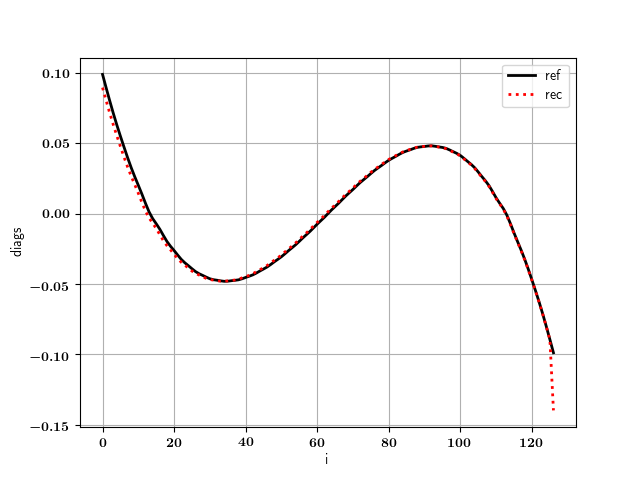

In [26]:
# ---------------------------------------------------------------------------------------
# --- Plot the constructed BE oracle ---
# ---------------------------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(qucf_r)
mix.reload_module(kvn)

diag_ch_1, id_shift, flag_real = np.array(diag_A_m1), -1, False
diag_ch_2 = oo_temp_ch.get_rec_y_sin_x()

# --- Read data from QuCF simulations ---
dd_loc    = qucf_r.read_matrix_sparse(
    "../QuCF/simulations/LCHS-KvN/", 
    "kvn_OUTPUT.hdf5"
) 

diag_rec = kvn.get_diag(dd_loc["A"].form_dense_matrix(), id_shift)[0]
if flag_real:
    diag_rec = diag_rec.real
else:
    diag_rec = diag_rec.imag

# diag_ch_1  = diag_ch_1[0:-1]  / np.max(np.abs(diag_ch_1[0:-1]))
# diag_ch_2  = diag_ch_2[0:-1]  / np.max(np.abs(diag_ch_2[0:-1]))
# diag_rec = diag_rec[0:-1] / np.max(np.abs(diag_rec[0:-1]))
    
diag_rec *= 2 # because, the BE returns non-rescaled values !!!


fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot(range(len(diag_ch_1)), diag_ch_1,  color="b", linewidth = 2, linestyle='-',label = "ref")
ax.plot(range(len(diag_ch_2)), diag_ch_2,  color="black", linewidth = 2, linestyle='-',label = "ref")
ax.plot(range(len(diag_rec)),  -diag_rec,   color="r", linewidth = 2, linestyle=':',label = "rec")
plt.xlabel('i')
plt.ylabel("diags")
plt.legend()
plt.grid(True)
plt.show() 

In [ ]:
# ---------------------------------------------------------------------------------------
# --- Correct OH at edge using edge elements of D-matrices and computed QSVT profiles ---
# ---------------------------------------------------------------------------------------

In [ ]:
# ***********************************************************************************************************
# ***********************************************************************************************************
# ***********************************************************************************************************

In [46]:
# -------------------------------------------------------------------------
# --- Read D-matrices computed by the QuCF ---
# -------------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(qucf_r)
mix.reload_module(kvn)

path_qc_ = "../QuCF/simulations/LCHS-KvN/matrices-D"

diff_n = [3, 4, 7]
dds_a = []
dds_k = []
for ii in range(len(diff_n)):
    print("--- Reading D-matrices for BE oracles of the matrix Aa for various nx.")
    fname_loc = "DA_n{:d}.hdf5".format(diff_n[ii])
    dd_loc    = qucf_r.read_matrix_sparse(path_qc_, fname_loc) 
    dds_a.append(dd_loc)

    print()
    print("--- Reading D-matrices for BE oracles of the matrix Ah for various nx.")
    fname_loc = "Dk-n{:d}.hdf5".format(diff_n[ii])
    dd_loc    = qucf_r.read_matrix_sparse(path_qc_, fname_loc) 
    dds_k.append(dd_loc)

--- Reading D-matrices for BE oracles of the matrix Aa for various nx.
Reading the matrix from: DA_n3.hdf5
from the path: ../QuCF/simulations/LCHS-KvN/matrices-D
date of the simulation:  02-05-2024 10:29:47
matrix name:  U
N = 8

--- Reading D-matrices for BE oracles of the matrix Ah for various nx.
Reading the matrix from: Dk-n3.hdf5
from the path: ../QuCF/simulations/LCHS-KvN/matrices-D
date of the simulation:  02-05-2024 10:35:09
matrix name:  U
N = 8
--- Reading D-matrices for BE oracles of the matrix Aa for various nx.
Reading the matrix from: DA_n4.hdf5
from the path: ../QuCF/simulations/LCHS-KvN/matrices-D
date of the simulation:  02-05-2024 10:33:29
matrix name:  U
N = 16

--- Reading D-matrices for BE oracles of the matrix Ah for various nx.
Reading the matrix from: Dk-n4.hdf5
from the path: ../QuCF/simulations/LCHS-KvN/matrices-D
date of the simulation:  02-05-2024 10:35:27
matrix name:  U
N = 16
--- Reading D-matrices for BE oracles of the matrix Aa for various nx.
Reading t

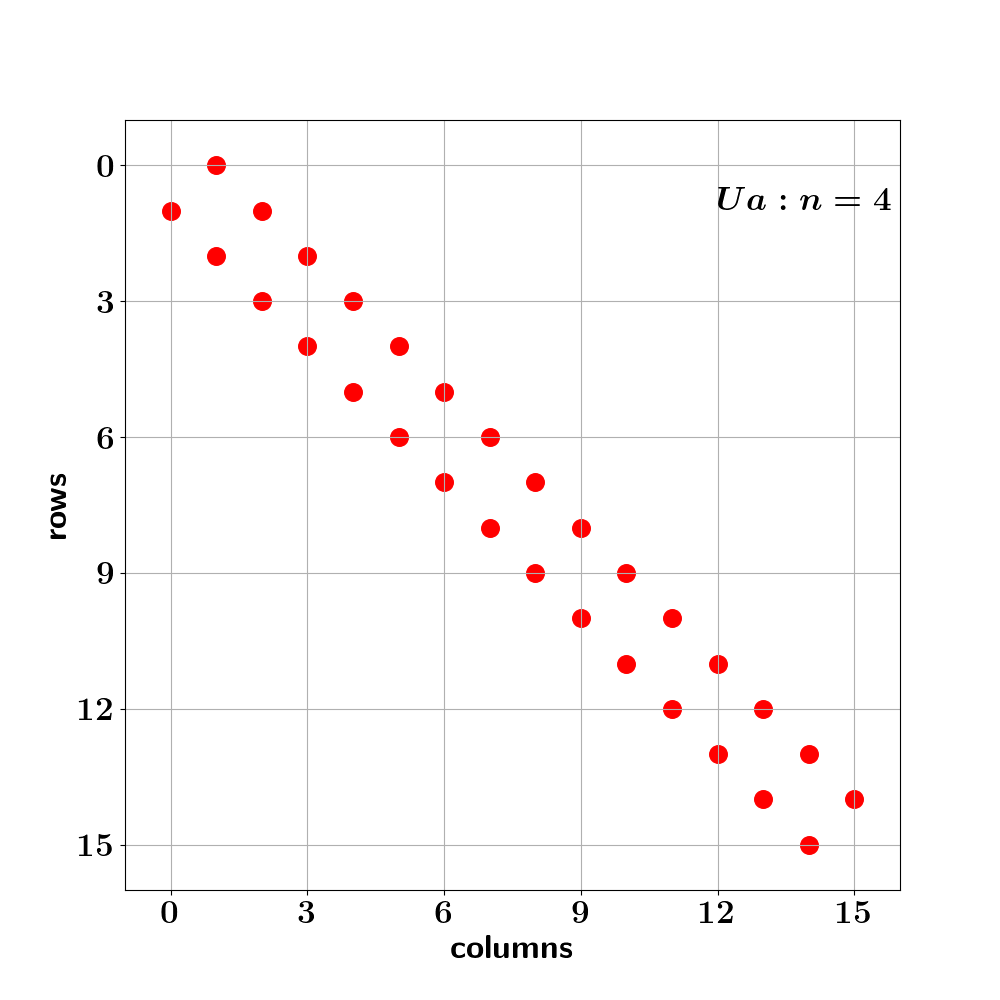

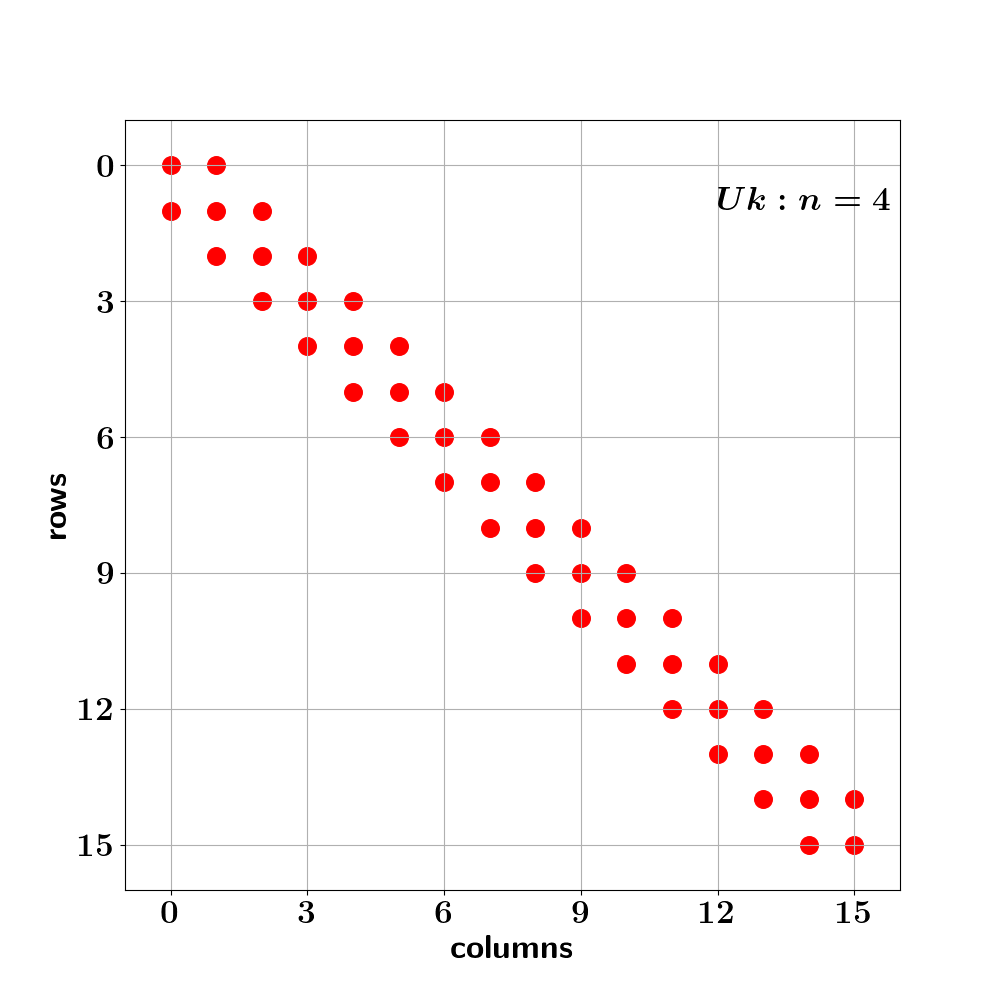

In [5]:
# -------------------------------------------------------------------------
# --- Plot structures of D-matrices computed by the QuCF ---
# -------------------------------------------------------------------------
id_plot = 1
dds_a[id_plot]["A"].plot_structure("Ua: n={:d}".format(diff_n[id_plot]))
dds_k[id_plot]["A"].plot_structure("Uk: n={:d}".format(diff_n[id_plot]))
del id_plot

In [47]:
# -------------------------------------------------------------------------
# --- Print and plot elements in D-matrices' ---
# These D-matrices have only real values.
# -------------------------------------------------------------------------
def print_plot_D_elements(id_shift, dds_print, str_matrix, flag_plot = False):
    colors = ["b", "r", "g"]
    markers = ["o", "s", "*"]

    # --- Printing ---
    print("--- Elements in {:s} in the diagonal {:d} ---".format(str_matrix, id_shift))
    print()
    for ii in range(len(diff_n)):
        mix.print_array(
            kvn.get_diag(dds_print[ii]["A"].form_dense_matrix(), id_shift)[0].real,
            n_in_row = 8,
            ff=[6, 3, "f"]
        )
        print()

    # --- Plotting ---
    if flag_plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        for i1 in range(len(diff_n)):
            ii = len(diff_n) - i1 - 1
            n1 = diff_n[ii]
            ax.plot(
                np.array(range((1<<n1) - np.abs(id_shift))), 
                kvn.get_diag(dds_print[ii]["A"].form_dense_matrix(), id_shift)[0].real, 
                color=colors[ii], linewidth = 2, linestyle='-', marker = markers[ii],
                label = "n = {:d}".format(n1)
            )
        plt.xlabel('i')
        plt.ylabel("v")
        plt.title(str_matrix + ": diag = {:d}".format(id_shift))
        plt.legend()
        plt.grid(True)
        plt.show() 
# -----------------------------------------------------------------------------------

id_shift =-1
dds_print, str_matrix = list(dds_a), "DA"
# dds_print, str_matrix = list(dds_k), "Dk"

print_plot_D_elements(id_shift, dds_print, str_matrix)
del id_shift, dds_print, str_matrix


--- Elements in DA in the diagonal -1 ---

 0.500  0.500  0.500  0.500  0.500  0.500  0.707 

 0.500  0.500  0.500  0.500  0.500  0.500  0.500  0.500 
 0.500  0.500  0.500  0.500  0.500  0.500  0.707 

 0.500  0.500  0.500  0.500  0.500  0.500  0.500  0.500 
 0.500  0.500  0.500  0.500  0.500  0.500  0.500  0.500 
 0.500  0.500  0.500  0.500  0.500  0.500  0.500  0.500 
 0.500  0.500  0.500  0.500  0.500  0.500  0.500  0.500 
 0.500  0.500  0.500  0.500  0.500  0.500  0.500  0.500 
 0.500  0.500  0.500  0.500  0.500  0.500  0.500  0.500 
 0.500  0.500  0.500  0.500  0.500  0.500  0.500  0.500 
 0.500  0.500  0.500  0.500  0.500  0.500  0.500  0.500 
 0.500  0.500  0.500  0.500  0.500  0.500  0.500  0.500 
 0.500  0.500  0.500  0.500  0.500  0.500  0.500  0.500 
 0.500  0.500  0.500  0.500  0.500  0.500  0.500  0.500 
 0.500  0.500  0.500  0.500  0.500  0.500  0.500  0.500 
 0.500  0.500  0.500  0.500  0.500  0.500  0.500  0.500 
 0.500  0.500  0.500  0.500  0.500  0.500  0.500  0.500 
